# DTMC

In [1]:
from switss.model import DTMC
import numpy as np
from switss.utils import color_from_hash

# setup the graph
# ----------------
E = [[0,1],[1,2],[2,0], [2, 1],[3,2],[3,1],[3,5],[4,2],[4,6],[5,4],[5,3],[6,4],[7,5],[7,6],[7,7]]
P = np.zeros(shape=(8,8))
for u,v in E:
    # initialize with arbitrary probabilities
    ucount = len([w for w,z in E if w == u])
    P[u,v] = 1/ucount
# ----------------

# create DTMC
dtmc = DTMC(P)

In [2]:
# get maximal end components from dtmc
mecs = dtmc.maximal_end_components()

components,proper_mecs,mec_counter = mecs

MEC amount: 6


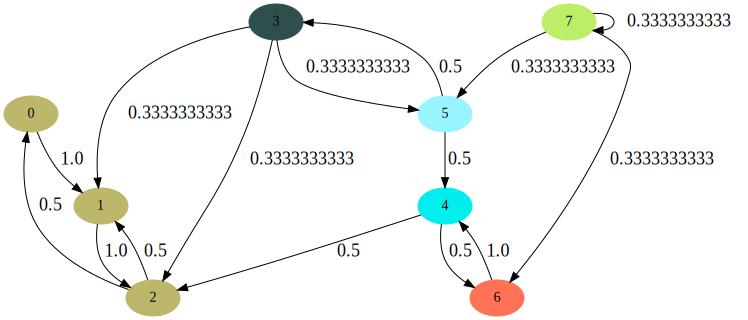

In [3]:
print("MEC amount:", mec_counter)

def sm(stateidx,labels):
    color = color_from_hash(7*components[stateidx])
    return { "color" : color, "style" : "filled" } 

dtmc.digraph(state_map=sm)

In [4]:
print("Index by state action: (from_state, action) <-> code")
for (from_state, action), code in dtmc.index_by_state_action.items():
    print(f'({from_state}, {action}) <-> {code}') 
print('\n')

print("Transitions:")
print(dtmc.P)

Index by state action: (from_state, action) <-> code
(0, 0) <-> 0
(1, 0) <-> 1
(2, 0) <-> 2
(3, 0) <-> 3
(4, 0) <-> 4
(5, 0) <-> 5
(6, 0) <-> 6
(7, 0) <-> 7


Transitions:
  (0, 1)	1.0
  (1, 2)	1.0
  (2, 0)	0.5
  (2, 1)	0.5
  (3, 1)	0.3333333333333333
  (3, 2)	0.3333333333333333
  (3, 5)	0.3333333333333333
  (4, 2)	0.5
  (4, 6)	0.5
  (5, 3)	0.5
  (5, 4)	0.5
  (6, 4)	1.0
  (7, 5)	0.3333333333333333
  (7, 6)	0.3333333333333333
  (7, 7)	0.3333333333333333


In [5]:
# get mec quotient mdp
q_mdp, original_inner_action_codes = dtmc.mec_quotient_mdp(mecs)

Component members:
Component 0 = A: [7]
Component 1 = B: [5]
Component 2 = C: [3]
Component 3 = D: [6]
Component 4 = E: [4]
Component 5 = F: [0, 1, 2]


Index by state action:
 (from_component, q_action = original dtmc action code) <-> q_code
(C, 3) <-> 0
(E, 4) <-> 1
(B, 5) <-> 2
(D, 6) <-> 3
(A, 7) <-> 4
(F, 8) <-> 5




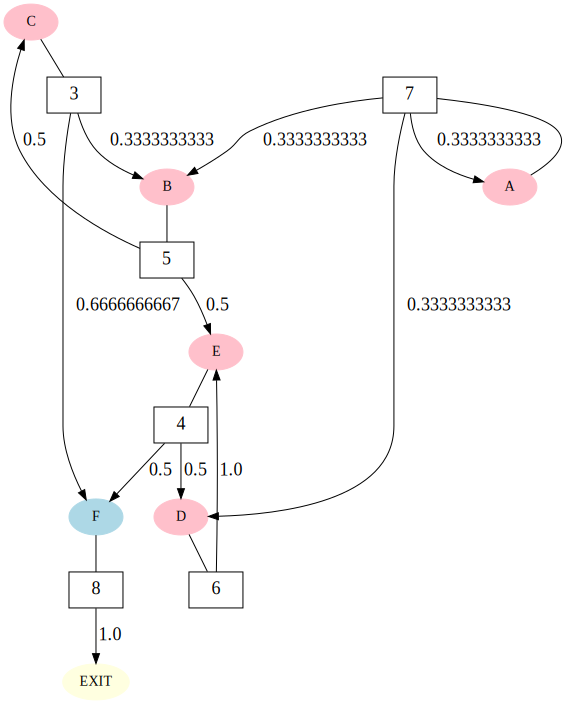

In [6]:
component_members = {}
for vertex, component in enumerate(components):
    if component not in component_members:
        component_members[component] = []
    component_members[component].append(vertex)

print("Component members:")
for compidx in range(mec_counter):
    print(f'Component {compidx} = {chr(ord('A') + compidx)}:', component_members[compidx])
print('\n')

print("Index by state action:\n (from_component, q_action = original dtmc action code) <-> q_code")
for (from_comp, action), code in q_mdp.index_by_state_action.items():
    print(f'({chr(ord('A') + from_comp)}, {action}) <-> {code}') 
print('\n')

def sm(compidx,labels):
    if compidx == mec_counter:
        color = "lightyellow"
        label = "EXIT"
    elif proper_mecs[compidx] == 1:
        color = "lightblue"
        label = chr(ord('A') + compidx)
    else:
        color = "pink"
        label = chr(ord('A') + compidx)
    return { "color" : color, "style" : "filled", "label" : label } 

### lightyellow component is an absorbing exit (and/or target); lighblue components are proper end components
q_mdp.digraph(state_map=sm)

In [7]:
# get system matrix of the mec quotient mdp
q_A = q_mdp.get_system_matrix()

In [8]:
from switss.solver import LP

# constraints count and variables count in the system matrix   
constraints = q_A.shape[0]
variables = q_A.shape[1]
# create matrix for LP from the system matrix and add constrainst for bounding the variables
A = np.concatenate((q_A, np.zeros(shape=(2*variables, variables))), axis=0)
b = np.array(list(constraints*[1]) + list(2*variables*[-1e9]))
opt = np.array(variables*[1])
for i in range(variables):
    A[(constraints + 2*i, i)] = 1
    A[(constraints + 2*i + 1, i)] = -1
# calculate the variables in the certificate for EC=freeness of the quotient mdp
lp = LP.from_coefficients(A,b,opt,sense=">=")
result = lp.solve(solver="gurobi")
mec_quotient_ec_free_cert = result.result_vector

for i in range(A.shape[0]):
    print(A[i], '* z >= ', b[i])
print('\n')
print(result)


[ 0.         -0.33333333  1.          0.          0.         -0.66666667
  0.        ] * z >=  1.0
[ 0.   0.   0.  -0.5  1.  -0.5  0. ] * z >=  1.0
[ 0.   1.  -0.5  0.  -0.5  0.   0. ] * z >=  1.0
[ 0.  0.  0.  1. -1.  0.  0.] * z >=  1.0
[ 0.66666667 -0.33333333  0.         -0.33333333  0.          0.
  0.        ] * z >=  1.0
[ 0.  0.  0.  0.  0.  1. -1.] * z >=  1.0
[1. 0. 0. 0. 0. 0. 0.] * z >=  -1000000000.0
[-1.  0.  0.  0.  0.  0.  0.] * z >=  -1000000000.0
[0. 1. 0. 0. 0. 0. 0.] * z >=  -1000000000.0
[ 0. -1.  0.  0.  0.  0.  0.] * z >=  -1000000000.0
[0. 0. 1. 0. 0. 0. 0.] * z >=  -1000000000.0
[ 0.  0. -1.  0.  0.  0.  0.] * z >=  -1000000000.0
[0. 0. 0. 1. 0. 0. 0.] * z >=  -1000000000.0
[ 0.  0.  0. -1.  0.  0.  0.] * z >=  -1000000000.0
[0. 0. 0. 0. 1. 0. 0.] * z >=  -1000000000.0
[ 0.  0.  0.  0. -1.  0.  0.] * z >=  -1000000000.0
[0. 0. 0. 0. 0. 1. 0.] * z >=  -1000000000.0
[ 0.  0.  0.  0.  0. -1.  0.] * z >=  -1000000000.0
[0. 0. 0. 0. 0. 0. 1.] * z >=  -1000000000.0
[

In [9]:
print("Multiply system Matrix with the certificate: ")
print(np.matmul(q_A, np.matrix(mec_quotient_ec_free_cert).transpose()))
print('\n')

Multiply system Matrix with the certificate: 
[[0.99999988]
 [1.        ]
 [1.00000006]
 [1.        ]
 [1.00099981]
 [1.        ]]




In [10]:
from switss.certification.mec_certificates import check_mec_certificate, generate_mec_certificate

mec_certificate = generate_mec_certificate(dtmc, mecs)

print("MEC quotient MPD EC-freeness certificate:")
print(mec_certificate[0])
print('\n')

print("MEC certificate is valid:", check_mec_certificate(dtmc, mecs, mec_certificate))
print('\n')

MEC quotient MPD EC-freeness certificate:
[-9.99999994e+08 -9.99999995e+08 -9.99999997e+08 -9.99999995e+08
 -9.99999996e+08 -9.99999999e+08 -1.00000000e+09]


MEC certificate is valid: True




# MDP

In [11]:
from switss.model import MDP
import numpy as np
from switss.utils import color_from_hash

# setup the graph
# ----------------
SAPpairs = [(3,0,5,0.2),(3,0,0,0.2),(2,0,1,0.7),(0,0,1,1),(1,0,2,1),(2,0,0,0.3),(3,0,2,0.6),(4,0,2,0.5),(3,1,5,1),(5,1,3,1),(5,0,4,1),(4,0,6,0.5),(6,0,4,1),(7,1,6,0.5),(7,1,5,0.5),(7,0,7,1)]
index_by_state_action = {(0,0):0,(1,0):1,(2,0):2,(3,0):3,(4,0):4,(3,1):5,(5,1):6,(5,0):7,(6,0):8,(7,1):9,(7,0):10}
P = np.zeros(shape=(11,8))
for s,a,d,p in SAPpairs:
    P[index_by_state_action[(s,a)],d] = p
# ----------/------

mdp = MDP(P,index_by_state_action)


In [12]:
# get maximal end components from mdp
mecs = mdp.maximal_end_components()

components,proper_mecs,mec_counter = mecs

MEC amount: 5


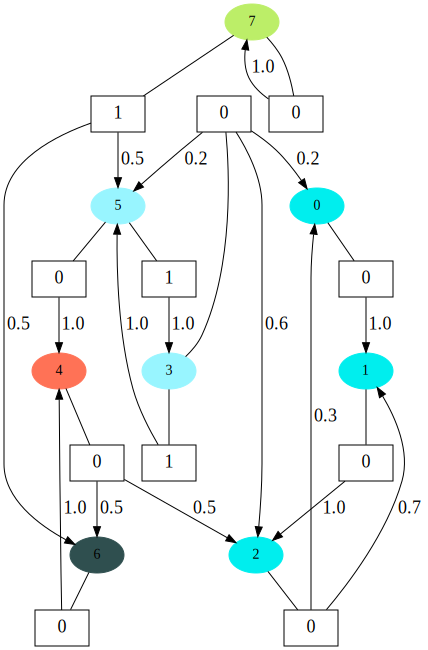

In [13]:
print("MEC amount:", mec_counter)

def sm(stateidx,labels):
    color = color_from_hash(7*components[stateidx])
    return { "color" : color, "style" : "filled" } 

mdp.digraph(state_map=sm)

In [14]:
print("Index by state action: (from_state, action) <-> code")
for (from_state, action), code in mdp.index_by_state_action.items():
    print(f'({from_state}, {action}) <-> {code}') 
print('\n')

print("Transitions:")
print(mdp.P)

Index by state action: (from_state, action) <-> code
(0, 0) <-> 0
(1, 0) <-> 1
(2, 0) <-> 2
(3, 0) <-> 3
(4, 0) <-> 4
(3, 1) <-> 5
(5, 1) <-> 6
(5, 0) <-> 7
(6, 0) <-> 8
(7, 1) <-> 9
(7, 0) <-> 10


Transitions:
  (0, 1)	1.0
  (1, 2)	1.0
  (2, 0)	0.3
  (2, 1)	0.7
  (3, 0)	0.2
  (3, 2)	0.6
  (3, 5)	0.2
  (4, 2)	0.5
  (4, 6)	0.5
  (5, 5)	1.0
  (6, 3)	1.0
  (7, 4)	1.0
  (8, 4)	1.0
  (9, 5)	0.5
  (9, 6)	0.5
  (10, 7)	1.0


In [15]:
# get mec quotient mdp
q_mdp, original_inner_action_codes = mdp.mec_quotient_mdp(mecs)

Component members:
Component 0 = A: [7]
Component 1 = B: [3, 5]
Component 2 = C: [6]
Component 3 = D: [4]
Component 4 = E: [0, 1, 2]


Index by state action:
 (from_component, q_action = original mdp action code) <-> q_code
(B, 3) <-> 0
(D, 4) <-> 1
(B, 7) <-> 2
(C, 8) <-> 3
(A, 9) <-> 4
(A, 11) <-> 5
(B, 11) <-> 6
(E, 11) <-> 7




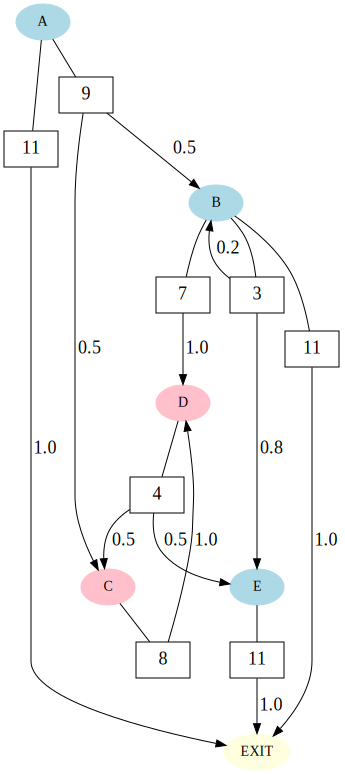

In [16]:
component_members = {}
for vertex, component in enumerate(components):
    if component not in component_members:
        component_members[component] = []
    component_members[component].append(vertex)

print("Component members:")
for compidx in range(mec_counter):
    print(f'Component {compidx} = {chr(ord('A') + compidx)}:', component_members[compidx])
print('\n')

print("Index by state action:\n (from_component, q_action = original mdp action code) <-> q_code")
for (from_comp, action), code in q_mdp.index_by_state_action.items():
    print(f'({chr(ord('A') + from_comp)}, {action}) <-> {code}') 
print('\n')

def sm(compidx,labels):
    if compidx == mec_counter:
        color = "lightyellow"
        label = "EXIT"
    elif proper_mecs[compidx] == 1:
        color = "lightblue"
        label = chr(ord('A') + compidx)
    else:
        color = "pink"
        label = chr(ord('A') + compidx)
    return { "color" : color, "style" : "filled", "label" : label } 

### lightyellow component is an absorbing exit (and/or target); lighblue components are proper end components
q_mdp.digraph(state_map=sm)

In [17]:
# get system matrix of the mec quotient mdp
q_A = q_mdp.get_system_matrix()

In [18]:
from switss.solver import LP

# constraints count and variables count in the system matrix   
constraints = q_A.shape[0]
variables = q_A.shape[1]
# create matrix for LP from the system matrix and add constrainst for bounding the variables
A = np.concatenate((q_A, np.zeros(shape=(2*variables, variables))), axis=0)
b = np.array(list(constraints*[1]) + list(2*variables*[-1e9]))
opt = np.array(variables*[1])
for i in range(variables):
    A[(constraints + 2*i, i)] = 1
    A[(constraints + 2*i + 1, i)] = -1
# calculate the variables in the certificate for EC=freeness of the quotient mdp
lp = LP.from_coefficients(A,b,opt,sense=">=")
result = lp.solve(solver="gurobi")
mec_quotient_ec_free_cert = result.result_vector

for i in range(A.shape[0]):
    print(A[i], '* z >= ', b[i])
print('\n')
print(result)

[ 0.   0.8  0.   0.  -0.8  0. ] * z >=  1.0
[ 0.   0.  -0.5  1.  -0.5  0. ] * z >=  1.0
[ 0.  1.  0. -1.  0.  0.] * z >=  1.0
[ 0.  0.  1. -1.  0.  0.] * z >=  1.0
[ 1.  -0.5 -0.5  0.   0.   0. ] * z >=  1.0
[ 1.  0.  0.  0.  0. -1.] * z >=  1.0
[ 0.  1.  0.  0.  0. -1.] * z >=  1.0
[ 0.  0.  0.  0.  1. -1.] * z >=  1.0
[1. 0. 0. 0. 0. 0.] * z >=  -1000000000.0
[-1.  0.  0.  0.  0.  0.] * z >=  -1000000000.0
[0. 1. 0. 0. 0. 0.] * z >=  -1000000000.0
[ 0. -1.  0.  0.  0.  0.] * z >=  -1000000000.0
[0. 0. 1. 0. 0. 0.] * z >=  -1000000000.0
[ 0.  0. -1.  0.  0.  0.] * z >=  -1000000000.0
[0. 0. 0. 1. 0. 0.] * z >=  -1000000000.0
[ 0.  0.  0. -1.  0.  0.] * z >=  -1000000000.0
[0. 0. 0. 0. 1. 0.] * z >=  -1000000000.0
[ 0.  0.  0.  0. -1.  0.] * z >=  -1000000000.0
[0. 0. 0. 0. 0. 1.] * z >=  -1000000000.0
[ 0.  0.  0.  0.  0. -1.] * z >=  -1000000000.0


SolverResult(status=optimal, result_vector=[-9.99999994e+08 -9.99999995e+08 -9.99999995e+08 -9.99999996e+08
 -9.99999999e+08 -1.00000000

In [19]:
print("Multiply system Matrix with the certificate: ")
print(np.matmul(q_A, np.matrix(mec_quotient_ec_free_cert).transpose()))

Multiply system Matrix with the certificate: 
[[3.20000005]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [6.        ]
 [5.        ]
 [1.        ]]


In [20]:
vertex_count = mdp.P.shape[1]

adj = {}  # adjacency list, contains only edges from inner actions
rev_adj = {}
for u in range(vertex_count):
    adj[u] = []
    rev_adj[u] = []

original_inner_action_codes = set(original_inner_action_codes)
for code, v_state in list(mdp.P.keys()):
    if code not in original_inner_action_codes:
        continue
    u_state, action = mdp.index_by_state_action.inv[code]
    if components[u_state] == components[v_state]:
        adj[u_state].append(v_state)
        rev_adj[v_state].append(u_state)

print("Adjacency list with only inner actions:")
for u, v_list in adj.items():
    print(u, '->', v_list)
print('\n')

print("Adjacency list (reversed) with only inner actions:")
for u, v_list in rev_adj.items():
    print(u, '->', v_list)

Adjacency list with only inner actions:
0 -> [1]
1 -> [2]
2 -> [0, 1]
3 -> [5]
4 -> []
5 -> [3]
6 -> []
7 -> [7]


Adjacency list (reversed) with only inner actions:
0 -> [2]
1 -> [0, 2]
2 -> [1]
3 -> [5]
4 -> []
5 -> [3]
6 -> []
7 -> [7]


In [21]:
from collections import deque

fwd = np.zeros(vertex_count, dtype=int)
bwd = np.zeros(vertex_count, dtype=int)
processed = np.zeros(vertex_count, dtype=bool)

def bfs(adjacent, source, cb):
    visited = np.zeros(vertex_count, dtype=bool)
    distance = np.zeros(vertex_count, dtype=int)
    queue = deque([source])
    visited[source] = processed[source] = True
    while len(queue) > 0:
        current_vertex = queue.popleft()
        cb(current_vertex, distance[current_vertex])
        for next_vertex in adjacent[current_vertex]:
            if visited[next_vertex]:
                continue
            visited[next_vertex] = processed[next_vertex] = True
            distance[next_vertex] = distance[current_vertex] + 1
            queue.append(next_vertex)

def set_fwd(vertex, dist):
    fwd[vertex] = dist

def set_bwd(vertex, dist):
    bwd[vertex] = dist

for u in range(vertex_count):
    if processed[u]:
        continue
    bfs(adj, u, set_bwd)
    bfs(rev_adj, u, set_fwd)

print("fwd:", fwd)
print("bwd:",bwd) 


fwd: [0 2 1 0 0 1 0 0]
bwd: [0 1 2 0 0 1 0 0]


In [22]:
from switss.certification.mec_certificates import check_mec_certificate, generate_mec_certificate

mec_certificate = generate_mec_certificate(mdp, mecs)

print("MEC quotient MPD EC-freeness certificate:")
print(mec_certificate[0])
print('\n')

print("MEC certificate is valid:", check_mec_certificate(mdp, mecs, mec_certificate))
print('\n')

 

MEC quotient MPD EC-freeness certificate:
[-9.99999994e+08 -9.99999995e+08 -9.99999995e+08 -9.99999996e+08
 -9.99999999e+08 -1.00000000e+09]


MEC certificate is valid: True


